---
# title: "FINC621 Winter 2018-19 Lab Worksheet 04"

### author: "Yu Jia"
### date: "12/7/2018"
### output:
  #### html_notebook: default
  #### html_document: default
subtitle: Stochastic Modeling & Numerical Differentiation (finc621-lab04)
---

### About

This worksheet looks at simulating, both arithmetics and geometric, Brownian motion for stock prices, pricing options, and calculating Greeks using numerical differentiation.  

### Setup

Remember to always set your working directory to the source file location. Go to 'Session', scroll down to 'Set Working Directory', and click 'To Source File Location'. Read carefully the below and follow the instructions to complete the tasks and answer any questions.  Submit your work to RPubs as detailed in previous notes. 

### Note

Always read carefully the instructions on Sakai.  For clarity, tasks/questions to be completed/answered are highlighted in red color (visible in preview) and numbered according to their particular placement in the task section.  Quite often you will need to add your own code chunk.

Execute all code chunks, preview, publish, and submit link on Sakai follwoing the naming convention. Make sure to add comments to your code where appropriate. Use own language!

### Task 1: Simulating Brownian Motion

This task follows the two examples in the book `R Example 5.1/p 148` for simulating an arithmetic Brownian motion and `R Example 5.2/p152` for simulating a geometric motion. Two new packages will be required for this worksheet.  They are included in the code chunk below.

In [6]:
from math import sqrt
from scipy.stats import norm
import numpy as np


def brownian(x0, alpha, sigma, T, n):
   
    # set a array for x0
    x0 = np.asarray(x0)
    dt=T/n
    
    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    r = norm.rvs(size=x0.shape + (n,), loc = alpha, scale = sigma*sqrt(dt))

    # store samples into arrary
    out = np.empty(r.shape)

    # This computes the Brownian motion by forming the cumulative sum of
    # the random samples. 
    np.cumsum(r, axis=-1, out=out)

    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)

    return out

<font color=red>##### 1A) Follow example in book to simulate and plot example of an arithmetic Brownian motion. Consider three values for n (number of points): $2^2, 2^5, 2^{12}$. Explain behavior as n increases.</font>

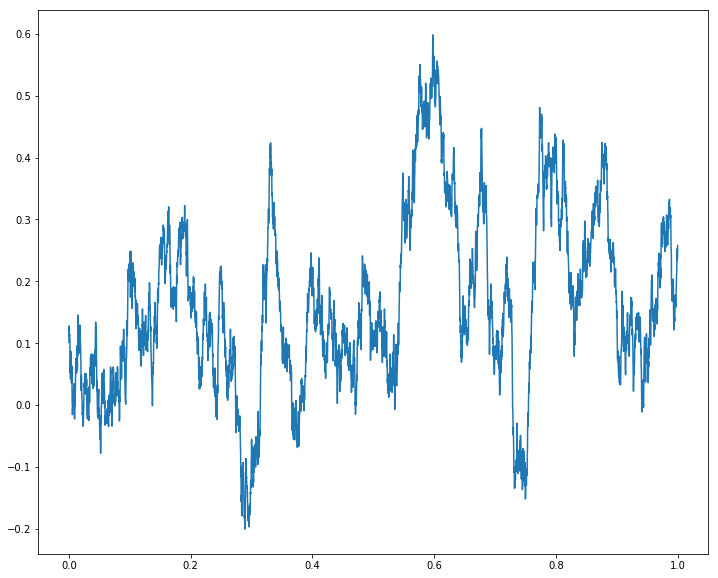

In [7]:
from scipy.stats import norm
import numpy
import matplotlib.pyplot as plt

# Process parameters
alpha=0
sigma=1
T=1
# Number of iterations to compute.
n = 2**12
# Initial condition.
X0 = 0.1
# time sequence
t = numpy.linspace(0.0,T,n,endpoint=True)
# Brownian motion
Xt=brownian(x0 = 0.1, alpha = 0, sigma = 1, T = 1, n = 2**12)
# plot arithmetic Brownian motion
plt.figure(figsize=(12,10))
plt.plot(t,Xt)


<font color=red>##### 1B) Write the mathematical equation representing the values along the y-axis in the above plot. Separately express what the value of each variable in the equation is.</font>

y-axis:$X_i=X_{i-1}+a*T/n+\sigma*\varepsilon_i*(T/n)^{0.5}$
in the equation above,$X_{i-1}=X0$ in begining,as time n value increases, $X_{i-1}$= previous X value.
$a=0$and T=1,$n=2^{12}$;$\sigma=1$;$\varepsilon_i$~N(0,1) normalised white noise, whihc is random nubmer.

<font color=red>##### 1C) Follow example in book to simulate a geometric Brownian motion.</font>

In [23]:
# Parameters
# So:     initial spot
# mu:     returns (drift coefficient)
# sigma:  volatility (diffusion coefficient)
# W:      brownian motion
# T:      time period
# N:      number of increments

def GBM(S0, mu, sigma, T, n):    
    t = np.linspace(0.,T,n+1)
    S = []
    S.append(S0)
    for i in range(1,int(n+1)):
        drift = (mu - 0.5 * sigma**2) * t[i]
        w = brownian(x0 = 0, alpha = 0, sigma = 1, T = T, n = n)
        diffusion = sigma * w[i-1]
        S_temp = S0*np.exp(drift + diffusion)
        S.append(S_temp)
    return S, t

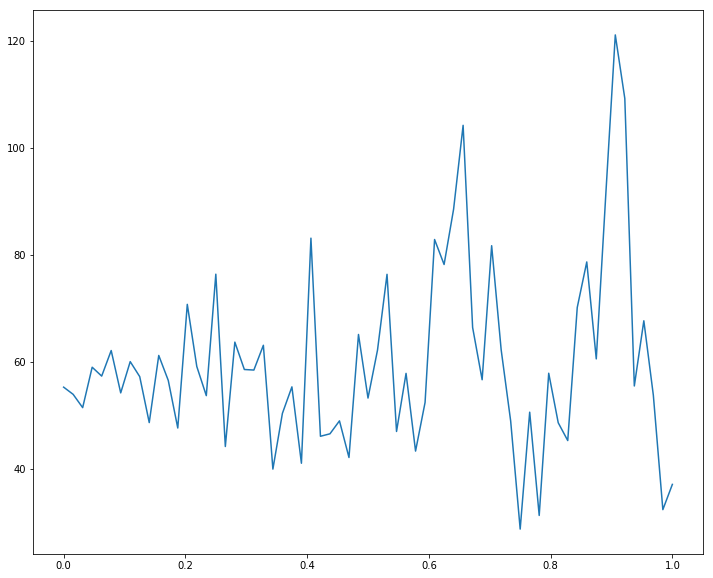

In [22]:
# assuming s0 is stock price, mu is mean of stock price, and sigma is standard deviation of stock price  
So = 55.25
mu = 0.15
sigma = 0.4
# parameters of GBM
T = 1
N = 2**6
# geometric Brownian motion
result=GBM(So, mu, sigma, T, N)
# adjust size of graph
plt.figure(figsize=(12,10))
# result[1] are geometric Brownian motion and result[0] are steps of time.
plot(result[1],result[0])

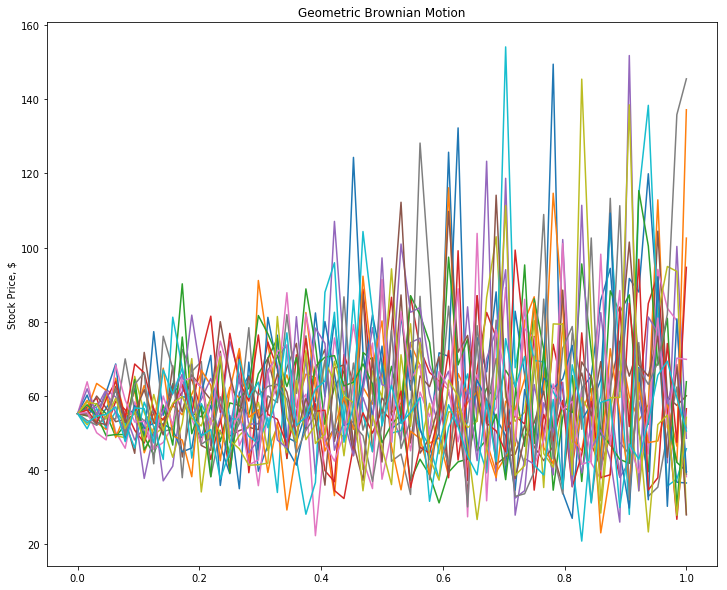

In [18]:
# it generates 20 potential geometric Brownian motion of stock price.
plt.figure(figsize=(12,10))
for _ in range(20):
    result = GBM(So, mu, sigma, T, N)
    plt.plot(result[1], result[0])
    plt.ylabel('Stock Price, $')
    plt.title('Geometric Brownian Motion')

<font color=red>##### 1D) Write the mathematical equation representing the values along the y-axis in the above plot. Separately express what the value of each variable in the equation is.</font>

$P_T=P_0 exp((u-1/2\sigma^{2})T+\sigma\varepsilon_t\Delta t^{0.5})$
In the equation abover,$P0=40$,$\sigma=0.2$,$T=1/12$,$u=0.16$,$\Delta t=T/n=0.00032552$,$\varepsilon_i$~N(0,1) normalised white noise, whihc is random number.

<font color=red>##### 1E) How is the geometric Brownian simulation different from the arithmetic simulation? Elaborate.</font>

In the arithmetic Brownian, x value may be a negative number, but all of x value is positive numbers in geometric Brownian. The difference between two Brownian simulations is caused by $\Delta x$ in geometric Brownian simulation. $\Delta x$ represents $lnP_{t+\Delta t}-lnP_t$.

### Task 2: Option Pricing, Greeks, and Numerical Differentiation

<font color=red>##### 2A) Calculate the Call and Put price of the given European Option.  Explain what the variables `r` and `b` in the function call `GBSOption` represent.</font>

In [24]:
import numpy as np
from scipy.stats import norm
# Black-Scholes-Merton option price
def BSM(S, K, T, r, sigma, optionType):
    # S is current stock price
    # K is strike price
    # T is tenor to expire on the option maturity
    # r is annualized rate of interest
    # sigma is the annualized volatulity of the underlying security
    # option is either call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if optionType == 'call':
        result = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
        
    if optionType == 'put':
        result = (K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0))
        
    return result


In [25]:
# parameters
# S0 = 60; K (strike price) = 65
# interest rate is 8%; volatility is 30%
# option type is call option 
BSM(S = 60, K = 65, T = 1/4, r = 0.08, sigma = 0.30, optionType = 'call')

2.1333684449162007

In [26]:
# parameters
# S0 = 60; K (strike price) = 65
# interest rate is 8%; volatility is 30%
# option type is put option 
BSM(S = 60, K = 65, T = 1/4, r = 0.08, sigma = 0.30, optionType = 'put')

5.846282209855289

<font color=red>##### 2B) Calculate the particular Greeks Delta, Gamma, and Vega for the above corresponding Call option.</font>

In [159]:
class  GBSGreeks():
    # Greek letter Delta method
    def Delta( S, K, T, r, sigma,optionType="c"): # # default is optionType="c"
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if optionType == "c":
        
            return norm.cdf(d1)
            
        elif optionType == "p":
            
            return norm.cdf(d1)-1
            
        
           
    # Greek letter Gamma method    
    def Gamma(S, K, T, r, sigma,optionType = "c"):
        
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        if optionType == "c" or optionType =="p":  
            return norm.pdf(d1)/(S*sigma*np.sqrt(T))
    # Greek letter Vega method  
    def Vega(S, K, T, r, sigma,optionType = "c"):
        
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        if optionType == "c" or optionType == "p": 
            return S*np.sqrt(T)*norm.pdf(d1)
    # Greek letter Theta method
    def Theta(S, K, T, r, sigma,optionType="c"): # # default is optionType="c"
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        if optionType == "c":
            
            return -S * sigma * norm.pdf(d1) / (2 * np.sqrt(T)) - K * r * np.exp(-r * T) * norm.cdf(d2)
        
        elif optionType == "p":
            
            return -S * sigma * norm.pdf(d1) / (2 * np.sqrt(T)) + K * r * np.exp(-r * T) * norm.cdf(d2)
        
    # Greek letter Rho method
    def Rho(S, K, T, r, sigma,optionType="c"): # # default is optionType="c"
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if optionType == "c":
            
            return K * T * np.exp(-r * T) * norm.cdf(d2)
        
        elif optionType == "p":
            
            return -K * T * np.exp(-r * T) * norm.cdf(-d2)  
        

In [162]:
GBSGreeks.Delta(S=60,K=65,T=1/4,r=0.08,sigma=0.30)

0.372482797961973

In [163]:
GBSGreeks.Gamma(S=60,K=65,T=1/4,r=0.08,sigma=0.30)

0.04204275575378518

In [164]:
GBSGreeks.Vega(S=60,K=65,T=1/4,r=0.08,sigma=0.30)

11.351544053522

In [165]:
GBSGreeks.Theta(S=60,K=65,T=1/4,r=0.08,sigma=0.30)

-8.428174386737375

In [166]:
GBSGreeks.Rho(S=60,K=65,T=1/4,r=0.08,sigma=0.30)

5.053899858200545

<font color=red>##### 2C) Calculate the Delta, Gamma, and Vega for same option using instead numerical differentiation. Write the mathematical equations corresponding to each numerical differentiation.</font>

The formula $f(x)=p_t\phi(d_1)-Ke^{-r(T-t)}\phi(d_2)$ is call option valuation function. using numerical differentiation $f(x_0+\Delta x)=f(x_0)+\int_{}^{n}\Delta x^n/n!+R_n(x)$ and $f(x_0-\Delta x)=f(x_0)+(-1)^n\int_{}^{n}\Delta x^n/n+R_n(x)$,the first order derivative is $f'(x_0)~(f(x_0+\Delta x)-f(x_0-\Delta x))/2\Delta x + R(x)$,and second odrder derivative is $f''(x_0)~(f(x_0+\Delta x)+f(x_0-\Delta x)-2f(x_0))/\Delta x ^2 + R(x)$.

when $p_0=60 and \Delta p=1$,Delta$\Delta$=$f'(p_0)$=$(f(p_0+\Delta p)-f(p_0-\Delta p))/2\Delta p + R(x)$=(2.5270-1.7817)/2=0.3726.

When $p_0=60 and \Delta p=1$,Gamma$\Gamma$=$f''(p_0)~(f(p_0+\Delta p)+f(p_0-\Delta p)-2f(p_0))/\Delta p ^2+ R(p)=((2.5270+1.7817)-2.1334*2)/2=0.0419$.

When $\sigma_0=0.3 and \Delta \sigma=0.01$,Vega$v$=$f'(\sigma_0)$=$(f(\sigma_0+\Delta \sigma)-f(\sigma_0-\Delta \sigma))/2\Delta \sigma + R(\sigma)$=(2.2472-2.0202)/0.02=11.35.

<font color=red>##### 2D) Compare results from 2B and 2C. Share observations.</font>

Compared results in 2B,Delta$\Delta$ is larger,Gamma$\Gamma$ is smaller and Vega$v$ is smaller. The difference between two group's results is caused by $R(x)$,whihc is error.